In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

# A Simple Regression*

Adapted from [unit 1: Regression.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit1/Regression.odc) and [unit 1: Regression.m](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit1/Regression.m).

The professor shows an example of Bayesian linear regression in BUGS, and compares it to how you would use MATLAB to perform one-least-squares regression. Don't worry about the details for now—this is more of a preview of where we're going in the second half of the class.

-------------------------------------------------

## Initial values

The professor often sets the initial values manually because BUGS will auto-generate really crazy initial values if you use wide priors.

This is not usually necessary in PyMC. The generated values are probably always going to be better than what you would have chosen. If a model is not running in PyMC and you suspect it is because of the initial values, instead of manually entering new ones select one of the [many other methods](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.init_nuts.html) for generating them by using the ```init``` parameter of ```pm.sample```. I've found the new ```"jitter+adapt_diag_grad"``` option really helpful here for certain models.

If you do need to set initial values, one way is to pass a dictionary with the keys as variable names to the ```initvals``` parameter of ```pm.sample```, like this:

```python
inits = {
    "alpha": np.array(0.0),
    "beta": np.array(0.0)
}

trace = pm.sample(2000, initvals=inits)
```

Here's the PyMC equivalent to Regression.odc:

In [2]:
# data
X = np.array([1, 2, 3, 4, 5])
y = np.array([1, 3, 3, 3, 5])
x_bar = np.mean(X)  # for mean centering

with pm.Model() as m:  # context manager with pm.Model class
    # priors
    alpha = pm.Normal("alpha", sigma=100)
    beta = pm.Normal("beta", sigma=100)
    # using the professor's standard precision prior
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)

    # what if we want to know sigma (std. dev.)?
    sigma = pm.Deterministic("sigma", 1 / (tau**0.5))

    mu = alpha + beta * (X - x_bar)

    # likelihood uses observed parameter to incorporate target data
    # the Normal dist can be specified either tau (precision) or sigma (stdev)
    pm.Normal("likelihood", mu=mu, tau=tau, observed=y)

    # start sampling and save results to trace variable
    trace = pm.sample(
        draws=3000,
        # chains=4,  # independent runs of the sampling process, for diagnostics
        # tune=500, # tuning sampler hyperparameters (these values are burned)
        # init="jitter+adapt_diag",  # method for choosing initial values
        # random_seed=1,
        # cores=4,  # parallel processing of chains
        # nuts_sampler="nutpie", # try a different NUTS implementation
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau]


Sampling 4 chains for 500 tune and 3_000 draw iterations (2_000 + 12_000 draws total) took 2 seconds.


Every semester, someone asks why the professor is mean-centering X. There are a few possible reasons, which are mostly not specific to Bayesian modeling. One might be interpretability—consider how the interpretation of the intercept alpha changes in a mean-centered model. A more Bayesian reason might be to help with sampling efficiency. The prior on the coefficient beta is going to be closer to the posterior if the data is mean-centered.

But don't worry about it for now. We go into regression after the midterm.

## Visualize your model structure

PyMC has a built-in method to visualize the structure of your model. It's really useful for making sure your code is doing what you intended.

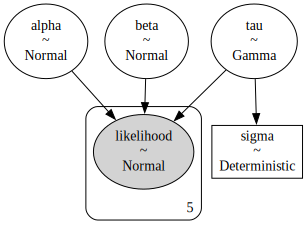

In [3]:
pm.model_to_graphviz(model=m)

## Tuning and burning samples

PyMC uses the tuning step specified in the ```pm.sample``` call to adjust various parameters in the No-U-Turn Sampler [(NUTS) algorithm](https://arxiv.org/abs/1111.4246), which is a form of Hamiltonian Monte Carlo. BUGS also silently uses different types of tuning depending on the algorithm it [chooses](https://www.york.ac.uk/depts/maths/histstat/pml1/bayes/winbugsinfo/cowles_winbugs.pdf). The professor also usually burns some number of samples in his examples. Note that this is separate from the tuning phase for both programs! 

We usually won't require students to burn PyMC samples separately from the tuning phase. So if a homework or exam problem specifies that you must burn 1000 samples, you can just set ```tune=1000``` in your ```pm.sample``` call and be done with it. That said, if for some reason you needed to burn samples from a PyMC trace after sampling, you could slice the trace (which is based on [xarray](https://docs.xarray.dev/en/stable/index.html)) like so:

In [4]:
# this burns the first 500 samples
trace_burned = trace.sel(draw=slice(500, None))

For some more detail on tuning, see [this post](https://colcarroll.github.io/hmc_tuning_talk/).

## ArViz for visualization and summary statistics

For visualization and summarization of your trace, use [ArViz](https://arviz-devs.github.io/arviz/).

Arviz has a variety of functions to view the results of the model. One of the most useful is ```az.summary```. Professor Vidakovic arbitrarily asks for the 95% credible set (also called the highest density interval), so we can specify hdi_prob=.95 to get that. This is the HPD, or minimum-width, credible set.

In [5]:
az.summary(trace_burned, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.003,0.553,1.933,4.002,0.009,0.007,4519.0,3418.0,1.0
beta,0.805,0.391,0.129,1.590,0.006,0.006,5311.0,3434.0,1.0
tau,1.857,1.507,0.008,4.821,0.027,0.019,2293.0,1931.0,1.0
sigma,1.013,0.752,0.336,2.156,0.018,0.013,2293.0,1931.0,1.0


You can also get the HDI directly:

In [6]:
az.hdi(trace_burned, hdi_prob=0.95)["beta"].values

array([0.1293742 , 1.58985855])

There are a variety of plots available. Commonly used to diagnose problems are the trace (see [When Traceplots go Bad](https://jpreszler.rbind.io/post/2019-09-28-bad-traceplots/)) and rank plots (see "Maybe it's time to let traceplots die" from [this post](https://statmodeling.stat.columbia.edu/2019/03/19/maybe-its-time-to-let-the-old-ways-die-or-we-broke-r-hat-so-now-we-have-to-fix-it/)).

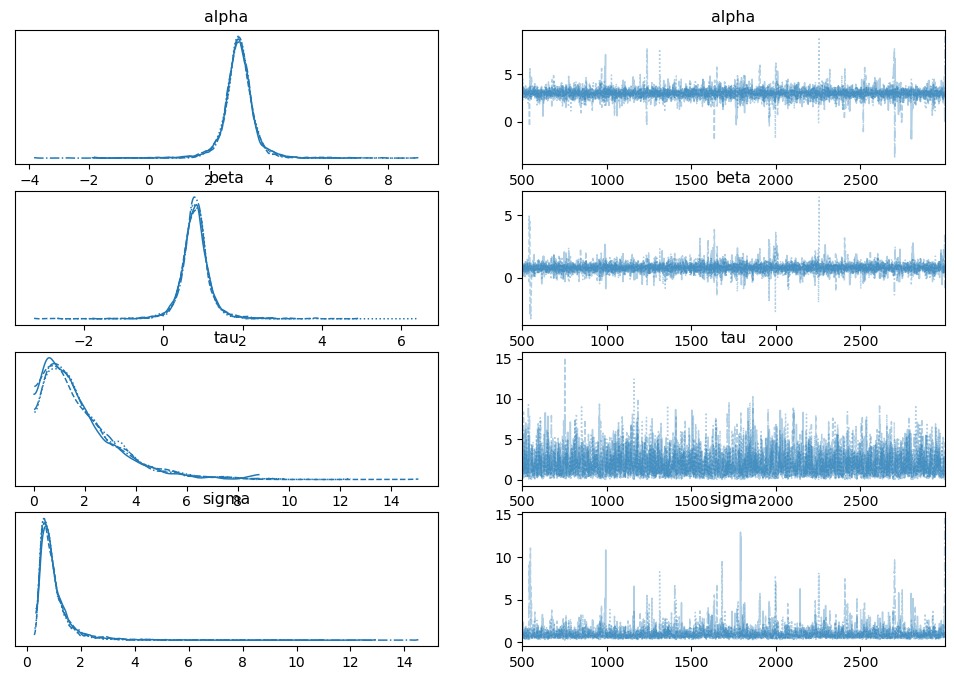

In [7]:
az.plot_trace(trace_burned)
plt.show()

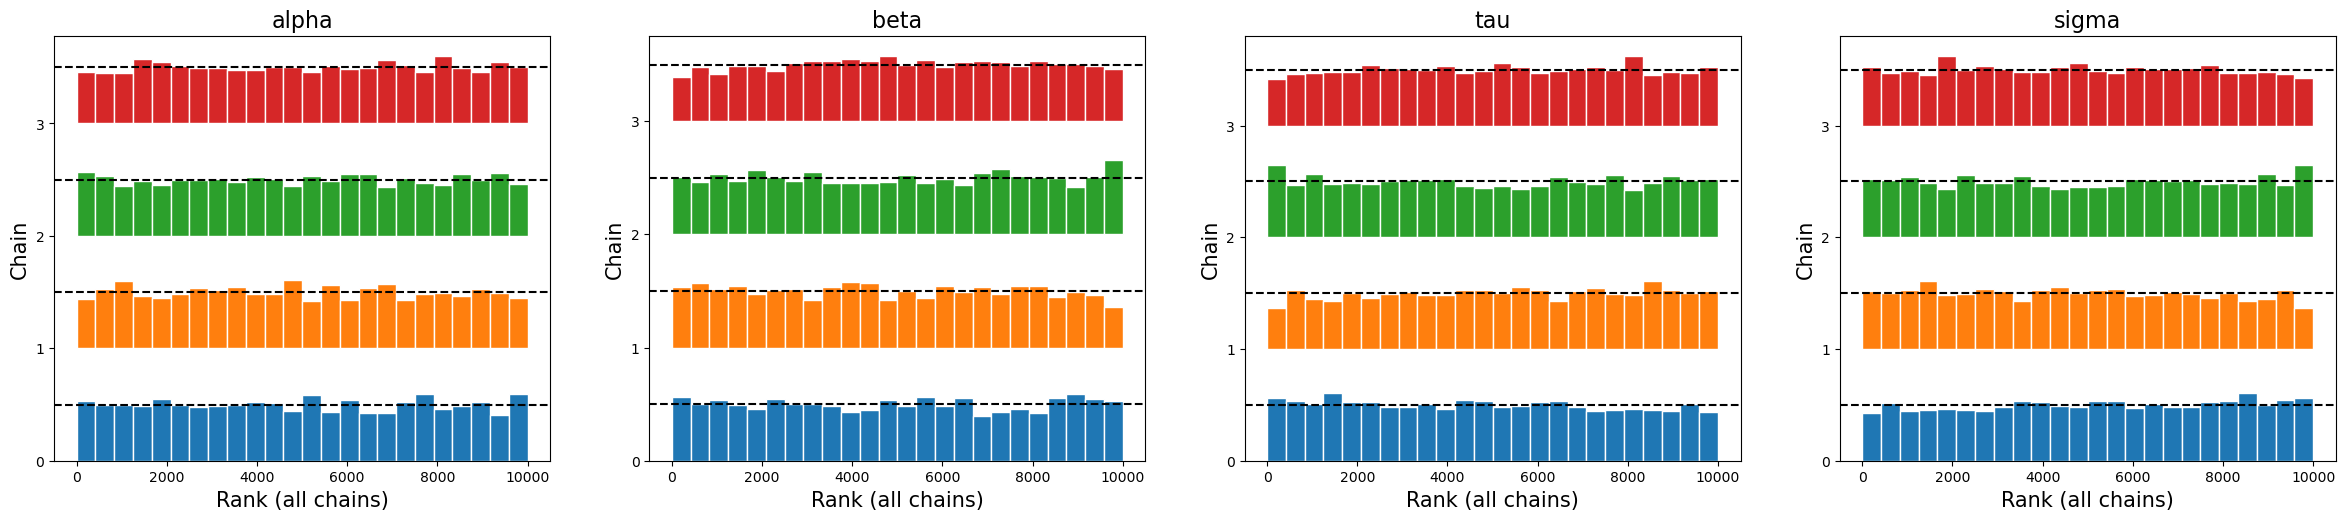

In [8]:
az.plot_rank(trace_burned)
plt.show()

## Comparison with a standard regression

There are many ways to manipulate Arviz [InferenceData](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html) objects to calculate statistics after sampling is complete.

In [9]:
# alpha - beta * x.bar
intercept = (
    trace_burned.posterior.alpha.mean()
    - trace_burned.posterior.beta.mean() * x_bar
)
intercept.values

array(0.58860146)

OpenBugs results from the lecture:

|       | mean   | sd     | MC_error | val2.5pc | median | val97.5pc | start | sample |
|-------|--------|--------|----------|----------|--------|-----------|-------|--------|
| alpha | 2.995  | 0.5388 | 0.005863 | 1.947    | 3.008  | 4.015     | 1000  | 9001   |
| beta  | 0.7963 | 0.3669 | 0.003795 | 0.08055  | 0.7936 | 1.526     | 1000  | 9001   |
| tau   | 1.88   | 1.524  | 0.02414  | 0.1416   | 1.484  | 5.79      | 1000  | 9001   |


Sometimes you might want to do a sanity check with classical regression. If your Bayesian regression has non-informative priors, the results should be close.

The two most well-known libraries for this in Python are [Scikit-learn](https://scikit-learn.org/stable/index.html) and [Statsmodels](https://www.statsmodels.org/). Sklearn is more focused on predictive modeling. If you're looking for nice summary printouts like ```lm()``` in R, Statsmodels will be more familiar.

In [10]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X.reshape(-1, 1), y)
# compare with intercept and beta from above
reg.intercept_, reg.coef_

(0.5999999999999996, array([0.8]))

In [11]:
import statsmodels.api as sm

X = sm.add_constant(X)  # add intercept column

results = sm.OLS(y, X).fit()
results.summary()

/Users/aaron/mambaforge/envs/pymc_env2/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     12.00
Date:                Mon, 15 May 2023   Prob (F-statistic):             0.0405
Time:                        22:51:58   Log-Likelihood:                -4.2461
No. Observations:                   5   AIC:                             12.49
Df Residuals:                       3   BIC:                             11.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6000      0.766      0.783      0.491      -1.838       3.038
x1             0.8000      0.231      3.464      0.041       0.065       1.535
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.600
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.352
Skew:                           0.000   Prob(JB):                        0.839
Kurtosis:                       1.700   Cond. No.                         8.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Mon May 15 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.9.0

pytensor: 2.11.1

statsmodels: 0.13.5
pymc       : 5.3.0
matplotlib : 3.6.3
numpy      : 1.24.2
arviz      : 0.15.1

